# DiploDatos - Entregable 5 - Unsupervised Machine Learning

Integrantes:

- Garay, Carolina del Valle
- Ormaechea, Sebastián Gabriel
- Ramos, Pablo Nicolás

Contenidos:

- Clustering
- Embeddings
- Aprendizaje Semi-Supervisado
- Reglas de Asociación


Práctico entregable: Utilizar la base de jugadores “players_22.csv” disponible en la página de Kaggle https://www.kaggle.com/datasets/stefanoleone992/fifa-22-complete-player-dataset . Considerar que la base 2022 no tiene el mismo formato que la base vista en clase, a los nombres de las variables se les agregó una keyword para identificar a qué tipo de habilidad corresponde.

Con la nueva base, realizar un análisis análogo al que realizamos en el cursado de la materia con los datos FIFA2019. Realice comentarios en cada parte (verbose=True ;))

1- Análisis exploratorio de la base.

2- Evaluación visual e intuitiva de a dos variables numéricas por vez.

3- Uso de dos técnicas de clustering: por ejemplo k-medias, DBSCAN, mezcla de Gaussianas y/o alguna jerárquica. Elección justificada de hiper-parámetros.

4- Evaluación y Análisis de los clusters encontrados. 

5- Pregunta: ¿Se realizó alguna normalización o escalado de la base? ¿Por qué?

6- Uso de alguna transformación (Proyección, Embedding) para visualizar los resultados y/o usarla como preprocesado para aplicar alguna técnica de clustering.

# Importar librerías

In [37]:
import os
import warnings
import numpy as np
import pandas as pd
import scipy.stats as stats


from collections import Counter
from wordcloud import WordCloud
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.cluster import KMeans, DBSCAN
from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn import metrics
from sklearn.datasets import make_blobs
from sklearn import decomposition
from sklearn.metrics import silhouette_score

from mlxtend.frequent_patterns import apriori, association_rules

from mpl_toolkits.mplot3d import Axes3D


warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 1000)

# Se carga el dataset 

In [2]:
df = pd.read_csv(os.path.join(os.getcwd(), "data", "players_22.csv"))

pd.options.display.float_format = "{:.1f}".format

In [3]:
print(df.shape)

(19239, 110)


In [4]:
df.describe()

,sofifa_id,overall,potential,value_eur,wage_eur,age,height_cm,weight_kg,club_team_id,league_level,club_jersey_number,club_contract_valid_until,nationality_id,nation_team_id,nation_jersey_number,weak_foot,skill_moves,international_reputation,release_clause_eur,pace,shooting,passing,dribbling,defending,physic,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking_awareness,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,goalkeeping_speed
count,19239.0,19239.0,19239.0,19165.0,19178.0,19239.0,19239.0,19239.0,19178.0,19178.0,19178.0,19178.0,19239.0,759.0,759.0,19239.0,19239.0,19239.0,18063.0,17107.0,17107.0,17107.0,17107.0,17107.0,17107.0,19239.0,19239.0,19239.0,19239.0,19239.0,19239.0,19239.0,19239.0,19239.0,19239.0,19239.0,19239.0,19239.0,19239.0,19239.0,19239.0,19239.0,19239.0,19239.0,19239.0,19239.0,19239.0,19239.0,19239.0,19239.0,19239.0,19239.0,19239.0,19239.0,19239.0,19239.0,19239.0,19239.0,19239.0,2132.0
mean,231468.1,65.8,71.1,2850451.8,9018.0,25.2,181.3,74.9,50580.5,1.4,20.9,2022.8,58.6,14480.8,12.6,2.9,2.4,1.1,5374044.1,68.2,52.3,57.3,62.6,51.7,64.8,49.6,45.9,51.8,58.9,42.5,55.7,47.3,42.2,53.1,58.5,64.7,64.7,63.5,61.5,64.1,57.8,64.8,63.1,65.0,46.6,55.5,46.6,50.3,54.0,47.9,57.9,46.6,48.0,45.9,16.4,16.2,16.1,16.2,16.5,36.4
std,27039.7,6.9,6.1,7613699.9,19470.2,4.7,6.9,7.1,54401.9,0.7,17.9,1.2,50.3,35328.7,7.0,0.7,0.8,0.4,14948368.0,10.9,14.1,10.1,9.7,16.2,9.8,18.0,19.7,17.3,14.5,17.7,18.8,18.2,17.2,15.0,16.7,15.2,15.0,14.9,9.0,14.3,13.2,12.1,16.1,12.7,19.4,17.0,20.7,19.6,13.7,15.8,12.2,20.2,21.2,20.8,17.6,16.8,16.6,17.1,17.9,10.8
min,41.0,47.0,49.0,9000.0,500.0,16.0,155.0,49.0,1.0,1.0,1.0,2021.0,1.0,1318.0,1.0,1.0,1.0,1.0,16000.0,28.0,18.0,25.0,27.0,14.0,29.0,6.0,2.0,5.0,7.0,3.0,4.0,6.0,4.0,9.0,8.0,14.0,15.0,18.0,25.0,15.0,20.0,22.0,12.0,19.0,4.0,10.0,3.0,2.0,10.0,7.0,12.0,4.0,5.0,5.0,2.0,2.0,2.0,2.0,2.0,15.0
25%,214413.5,61.0,67.0,475000.0,1000.0,21.0,176.0,70.0,479.0,1.0,9.0,2022.0,21.0,1338.0,7.0,3.0,2.0,1.0,806000.0,62.0,42.0,51.0,57.0,37.0,59.0,38.0,30.0,44.0,54.0,30.0,50.0,35.0,31.0,44.0,55.0,57.0,58.0,55.0,56.0,56.0,48.0,57.0,56.0,57.0,32.0,44.0,26.0,40.0,45.0,38.0,50.0,29.0,28.0,25.0,8.0,8.0,8.0,8.0,8.0,27.0
50%,236543.0,66.0,71.0,975000.0,3000.0,25.0,181.0,75.0,1938.0,1.0,18.0,2022.0,45.0,1357.0,12.0,3.0,2.0,1.0,1600000.0,69.0,54.0,58.0,64.0,56.0,66.0,54.0,50.0,55.0,62.0,43.0,61.0,49.0,41.0,56.0,63.0,67.0,68.0,66.0,62.0,66.0,59.0,65.0,66.0,66.0,51.0,58.0,53.0,56.0,55.0,49.0,59.0,52.0,56.0,53.0,11.0,11.0,11.0,11.0,11.0,36.0
75%,253532.5,70.0,75.0,2000000.0,8000.0,29.0,186.0,80.0,111139.0,1.0,27.0,2024.0,60.0,1386.0,19.0,3.0,3.0,1.0,3700000.0,76.0,63.0,64.0,69.0,64.0,72.0,63.0,62.0,64.0,68.0,56.0,68.0,61.0,55.0,64.0,69.0,75.0,75.0,74.0,67.0,74.0,68.0,73.0,74.0,74.0,62.0,68.0,64.0,64.0,64.0,60.0,66.0,63.0,65.0,63.0,14.0,14.0,14.0,14.0,14.0,45.0
max,264640.0,93.0,95.0,194000000.0,350000.0,54.0,206.0,110.0,115820.0,5.0,99.0,2031.0,219.0,111473.0,28.0,5.0,5.0,5.0,373500000.0,97.0,94.0,93.0,95.0,91.0,90.0,94.0,95.0,93.0,94.0,90.0,96.0,94.0,94.0,93.0,96.0,97.0,97.0,96.0,94.0,96.0,95.0,95.0,97.0,97.0,94.0,95.0,91.0,96.0,95.0,93.0,96.0,93.0,93.0,92.0,91.0,92.0,93.0,92.0,90.0,65.0


In [5]:
sorted(df.columns)

['age',
 'attacking_crossing',
 'attacking_finishing',
 'attacking_heading_accuracy',
 'attacking_short_passing',
 'attacking_volleys',
 'body_type',
 'cam',
 'cb',
 'cdm',
 'cf',
 'club_contract_valid_until',
 'club_flag_url',
 'club_jersey_number',
 'club_joined',
 'club_loaned_from',
 'club_logo_url',
 'club_name',
 'club_position',
 'club_team_id',
 'cm',
 'defending',
 'defending_marking_awareness',
 'defending_sliding_tackle',
 'defending_standing_tackle',
 'dob',
 'dribbling',
 'gk',
 'goalkeeping_diving',
 'goalkeeping_handling',
 'goalkeeping_kicking',
 'goalkeeping_positioning',
 'goalkeeping_reflexes',
 'goalkeeping_speed',
 'height_cm',
 'international_reputation',
 'lam',
 'lb',
 'lcb',
 'lcm',
 'ldm',
 'league_level',
 'league_name',
 'lf',
 'lm',
 'long_name',
 'ls',
 'lw',
 'lwb',
 'mentality_aggression',
 'mentality_composure',
 'mentality_interceptions',
 'mentality_penalties',
 'mentality_positioning',
 'mentality_vision',
 'movement_acceleration',
 'movement_agility

In [6]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19239 entries, 0 to 19238
Data columns (total 110 columns):
 #    Column                       Dtype  
---   ------                       -----  
 0    sofifa_id                    int64  
 1    player_url                   object 
 2    short_name                   object 
 3    long_name                    object 
 4    player_positions             object 
 5    overall                      int64  
 6    potential                    int64  
 7    value_eur                    float64
 8    wage_eur                     float64
 9    age                          int64  
 10   dob                          object 
 11   height_cm                    int64  
 12   weight_kg                    int64  
 13   club_team_id                 float64
 14   club_name                    object 
 15   league_name                  object 
 16   league_level                 float64
 17   club_position                object 
 18   club_jersey_number      

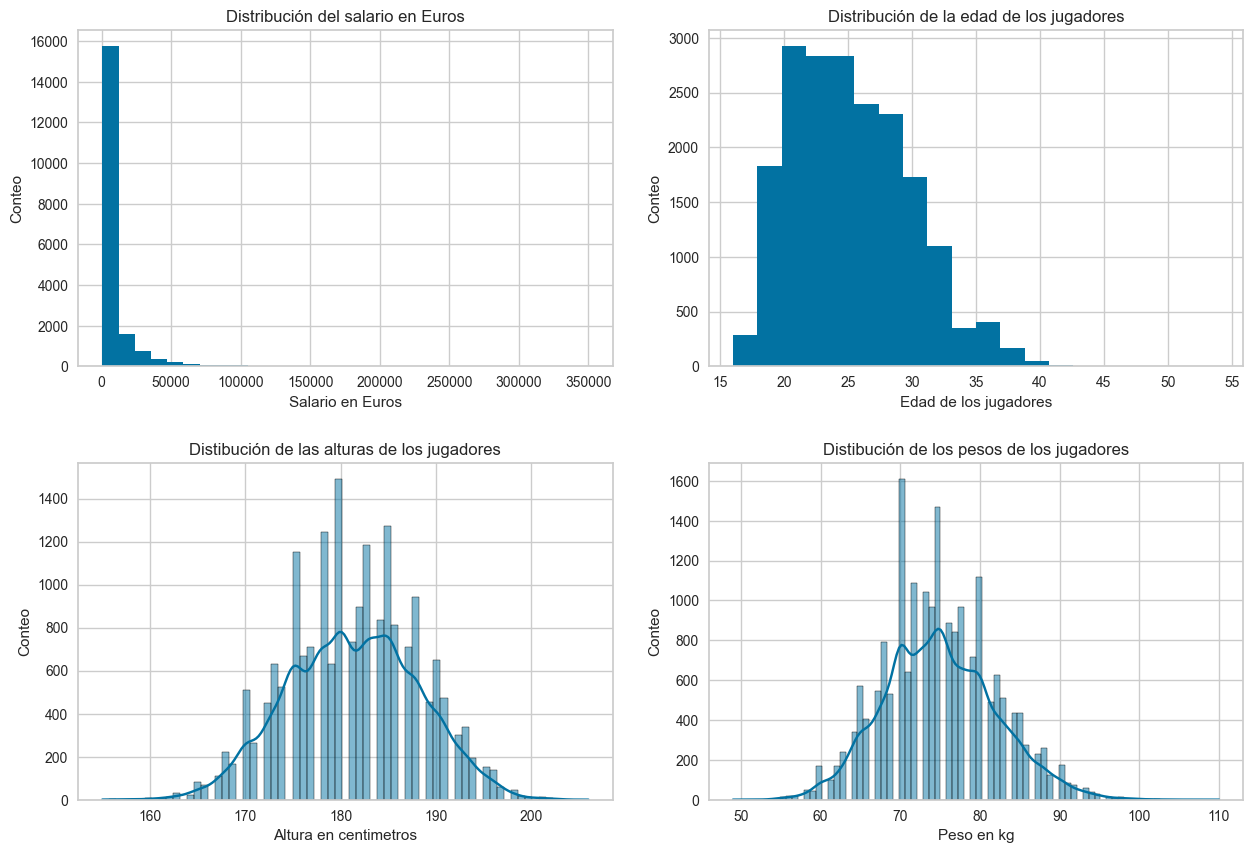

In [7]:
# Visualización de algunas variables de interés
fig, axes = plt.subplots(2, 2, figsize=(13, 9))
axes[0,0].hist(df["wage_eur"], bins=30)
axes[0,0].set_xlabel("Salario en Euros")
axes[0,0].set_ylabel("Conteo")
axes[0,0].set_title("Distribución del salario en Euros")

axes[0,1].hist(df["age"], bins = 20)
axes[0,1].set_xlabel("Edad de los jugadores")
axes[0,1].set_ylabel("Conteo")
axes[0,1].set_title("Distribución de la edad de los jugadores")

axes[1,0].set_title("Distibución de las alturas de los jugadores")
sns.histplot(df, x="height_cm", ax=axes[1,0], kde=True)
axes[1,0].set_xlabel("Altura en centimetros")
axes[1,0].set_ylabel("Conteo")

axes[1,1].set_title("Distibución de los pesos de los jugadores")
sns.histplot(df, x="weight_kg", ax=axes[1,1], kde=True)
axes[1,1].set_xlabel("Peso en kg")
axes[1,1].set_ylabel("Conteo")

plt.tight_layout(pad=2)
plt.show()

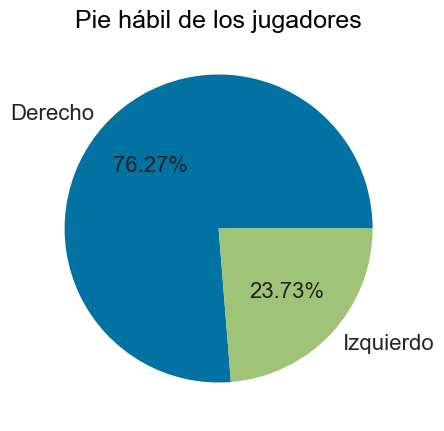

In [8]:
# Inspeccionamos cuál es el pie hábil de los jugadores en su mayoría
preferred_foot_labels = df["preferred_foot"].value_counts().index # (Derecho, Izquierdo) 
preferred_foot_values = df["preferred_foot"].value_counts().values # (Valores para el derecho, Valores para el izquierdo)
explode = (0, 0.1) # Esto se usa para hacer la separación en el gráfico

# Visualizamos incluyendo porcentajes usando autopct
plt.figure(figsize = (5,5))
plt.pie(preferred_foot_values, labels=['Derecho', 'Izquierdo'], autopct='%1.2f%%', textprops={'fontsize': 16})
plt.title('Pie hábil de los jugadores', color = 'black',fontsize = 18)
plt.show()

In [9]:
# Inspeccionamos y visualizamos las nacionalidades
nationality_count = df["nationality_name"].value_counts()\
    .reset_index()\
    .rename(columns={"index": 'nationality', "nationality_name": "nationality_count"})

for i, row in enumerate(nationality_count.itertuples(), 0):
    print(row)

Pandas(Index=0, nationality='England', nationality_count=1719)
Pandas(Index=1, nationality='Germany', nationality_count=1214)
Pandas(Index=2, nationality='Spain', nationality_count=1086)
Pandas(Index=3, nationality='France', nationality_count=980)
Pandas(Index=4, nationality='Argentina', nationality_count=960)
Pandas(Index=5, nationality='Brazil', nationality_count=897)
Pandas(Index=6, nationality='Japan', nationality_count=546)
Pandas(Index=7, nationality='Netherlands', nationality_count=439)
Pandas(Index=8, nationality='United States', nationality_count=413)
Pandas(Index=9, nationality='Poland', nationality_count=403)
Pandas(Index=10, nationality='China PR', nationality_count=385)
Pandas(Index=11, nationality='Sweden', nationality_count=385)
Pandas(Index=12, nationality='Norway', nationality_count=379)
Pandas(Index=13, nationality='Republic of Ireland', nationality_count=374)
Pandas(Index=14, nationality='Portugal', nationality_count=373)
Pandas(Index=15, nationality='Saudi Arabia', 

In [10]:
# Se filtran las nacionalidades mas populares
new_df = nationality_count.copy()
new_df = new_df.head(15)
new_df

,nationality,nationality_count
0,England,1719
1,Germany,1214
2,Spain,1086
3,France,980
4,Argentina,960
5,Brazil,897
6,Japan,546
7,Netherlands,439
8,United States,413
9,Poland,403


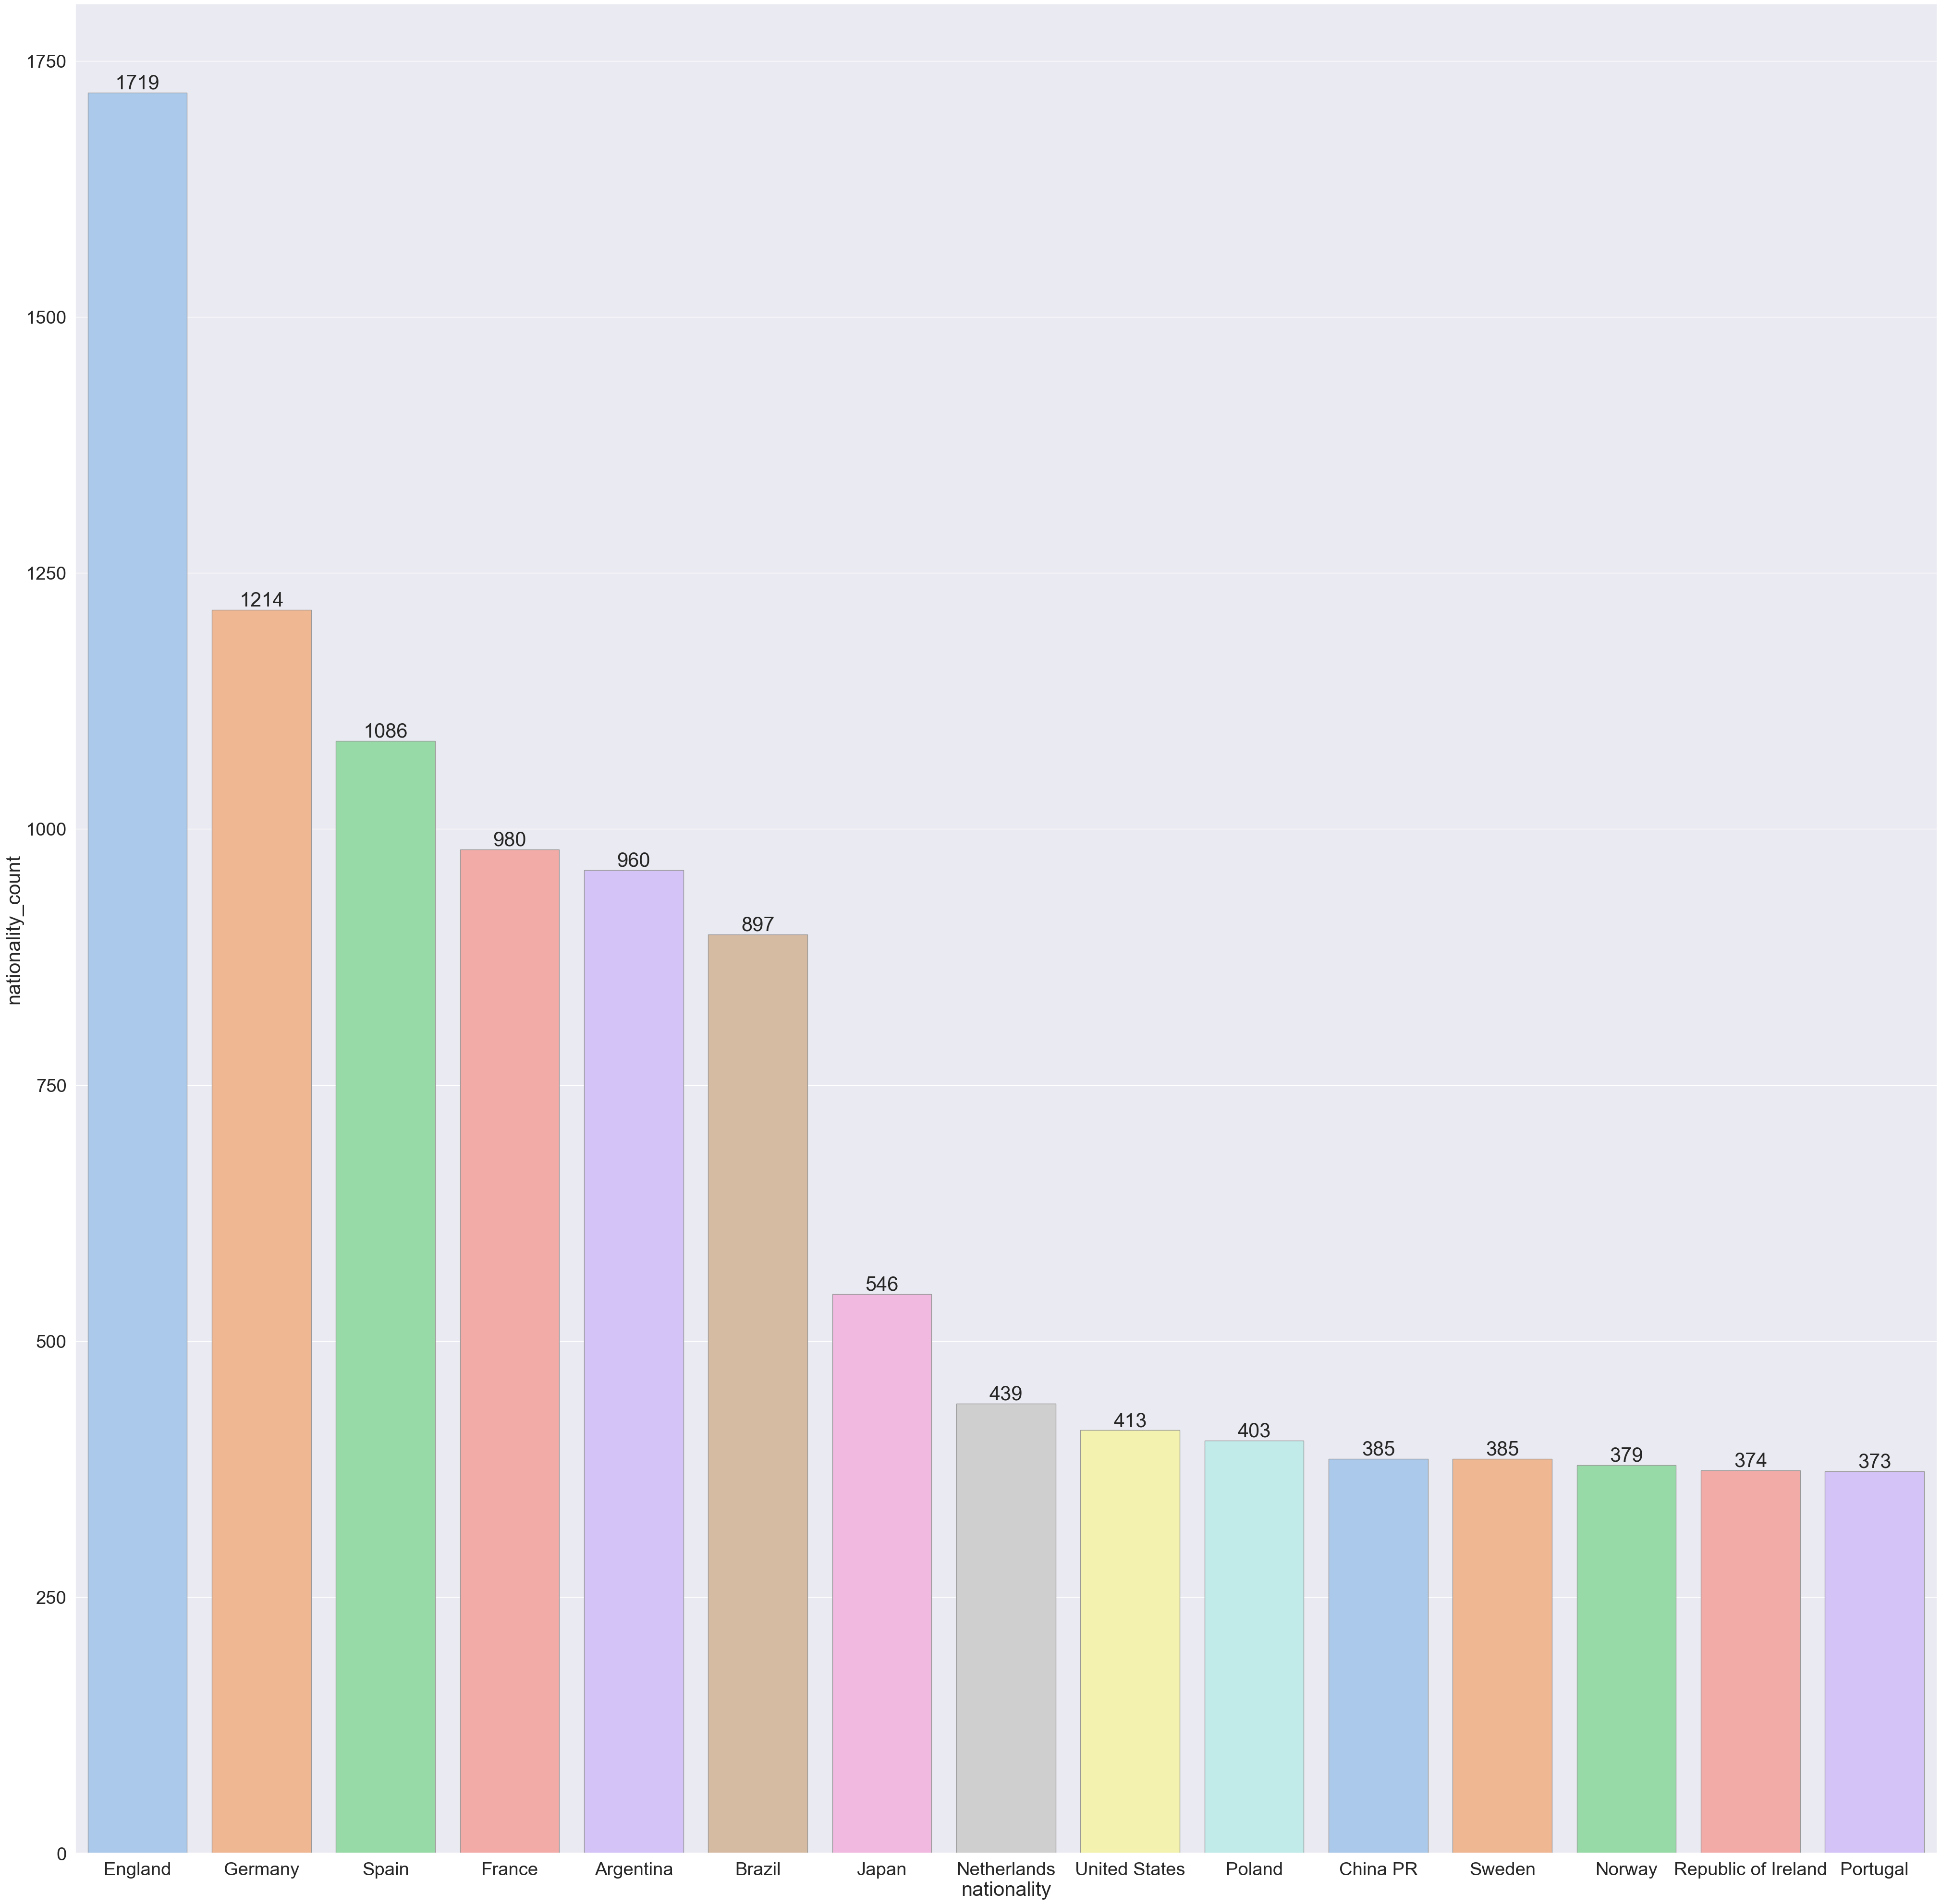

In [11]:
plt.figure(figsize=(50,50))

sns.set(font_scale=2.5)

plt.xlabel("nationality")
plt.ylabel("nationality_count")

ax = sns.barplot(x="nationality", y="nationality_count", palette="pastel", edgecolor=".6", data=new_df)
ax.bar_label(ax.containers[0])
sns.despine()

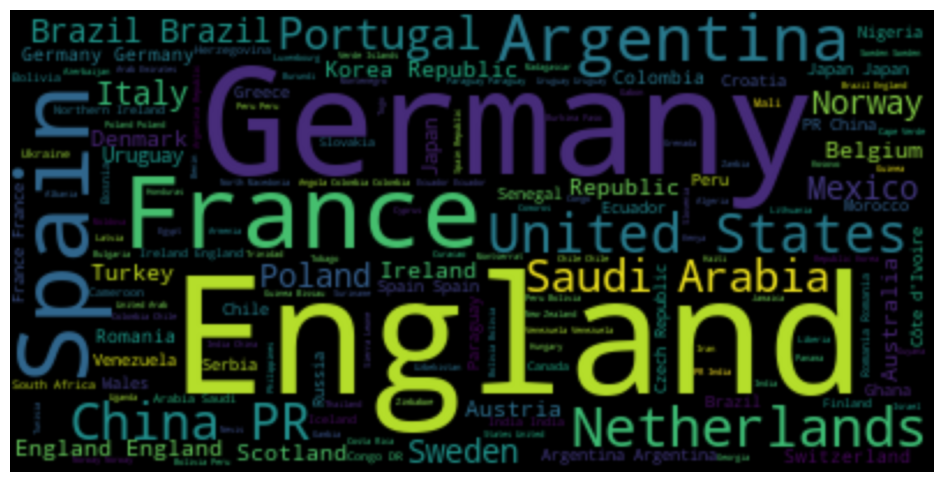

In [12]:
# Visualización alternativa de naciones más populares
nationality_name = " ".join(n for n in df["nationality_name"])
plt.figure(figsize=(18, 6)) 
wc = WordCloud().generate(nationality_name) 
plt.imshow(wc, interpolation="gaussian") 
plt.axis("off") 
plt.show()

# A continuación, se aplican las buenas prácticas de Minería de Datos para descubrir patrones desconocidos, a priori, en el dataset suministrado

El preprocesamiento de datos es una técnica de minería de datos que transforma los datos sin procesar en un formato comprensible para los algoritmos de ML. Los datos del mundo real generalmente poseen ruido (contienen errores, valores atípicos, duplicados), están incompletos (se pierden algunos valores), se pueden almacenar en diferentes lugares y en diferentes formatos. La tarea del preprocesamiento de datos es manejar estos problemas.


En un pipeline de ML, la etapa de preprocesamiento de datos se encuentra entre la etapa de recopilación de datos y el modelo de entrenamiento/ajuste.

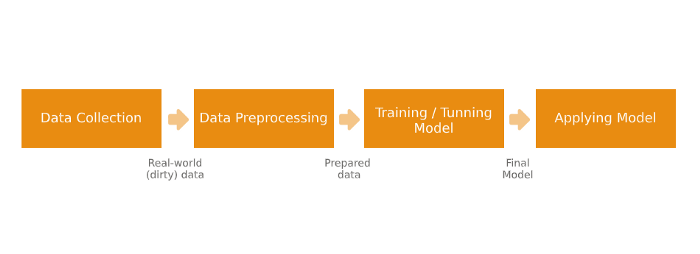

# 1. Data Cleaning

1.1. Removing duplicates

In [13]:
data = df.copy()
data.drop_duplicates(inplace=True)
data = data.reset_index(drop=True)


print(data.shape)

(19239, 110)


1.2. Removing unnecessary columns

In [14]:
# Se identifican las variables numéricas
data_nums = data.select_dtypes("number")

# Se inspecciona qué variables tienen datos faltantes para luego no contemplarlas
data_nums.isnull().sum()

sofifa_id                          0
overall                            0
potential                          0
value_eur                         74
wage_eur                          61
age                                0
height_cm                          0
weight_kg                          0
club_team_id                      61
league_level                      61
club_jersey_number                61
club_contract_valid_until         61
nationality_id                     0
nation_team_id                 18480
nation_jersey_number           18480
weak_foot                          0
skill_moves                        0
international_reputation           0
release_clause_eur              1176
pace                            2132
shooting                        2132
passing                         2132
dribbling                       2132
defending                       2132
physic                          2132
attacking_crossing                 0
attacking_finishing                0
a

In [15]:
# Se identifican las variables no numéricas
lista_nums = data_nums.columns.to_list()

lista_cols = data.columns.to_list()

lista_not_num = [x for x in lista_cols if x not in lista_nums]

print(lista_not_num)

['player_url', 'short_name', 'long_name', 'player_positions', 'dob', 'club_name', 'league_name', 'club_position', 'club_loaned_from', 'club_joined', 'nationality_name', 'nation_position', 'preferred_foot', 'work_rate', 'body_type', 'real_face', 'player_tags', 'player_traits', 'ls', 'st', 'rs', 'lw', 'lf', 'cf', 'rf', 'rw', 'lam', 'cam', 'ram', 'lm', 'lcm', 'cm', 'rcm', 'rm', 'lwb', 'ldm', 'cdm', 'rdm', 'rwb', 'lb', 'lcb', 'cb', 'rcb', 'rb', 'gk', 'player_face_url', 'club_logo_url', 'club_flag_url', 'nation_logo_url', 'nation_flag_url']


In [16]:
# Prescindimos de columnas con datos Nan y aquellas con ids ya que estas últimas no aportan información para clustering
df_nums_proc = data_nums.dropna(axis=1, how="any")
df_nums_proc.drop(columns=["sofifa_id", "nationality_id"], inplace=True)
df_nums_proc.columns

Index(['overall', 'potential', 'age', 'height_cm', 'weight_kg', 'weak_foot',
       'skill_moves', 'international_reputation', 'attacking_crossing',
       'attacking_finishing', 'attacking_heading_accuracy',
       'attacking_short_passing', 'attacking_volleys', 'skill_dribbling',
       'skill_curve', 'skill_fk_accuracy', 'skill_long_passing',
       'skill_ball_control', 'movement_acceleration', 'movement_sprint_speed',
       'movement_agility', 'movement_reactions', 'movement_balance',
       'power_shot_power', 'power_jumping', 'power_stamina', 'power_strength',
       'power_long_shots', 'mentality_aggression', 'mentality_interceptions',
       'mentality_positioning', 'mentality_vision', 'mentality_penalties',
       'mentality_composure', 'defending_marking_awareness',
       'defending_standing_tackle', 'defending_sliding_tackle',
       'goalkeeping_diving', 'goalkeeping_handling', 'goalkeeping_kicking',
       'goalkeeping_positioning', 'goalkeeping_reflexes'],
      dtype=

In [17]:
# En base a la limpieza anterior, definimos las variables relacionadas específicamente con habilidades en el objeto Skills
     
Skills = ['attacking_crossing', 'attacking_finishing', 'attacking_heading_accuracy', 
          'attacking_short_passing', 'attacking_volleys', 'skill_dribbling', 
          'skill_curve', 'skill_fk_accuracy', 'skill_long_passing', 'skill_ball_control', 
          'movement_acceleration', 'movement_sprint_speed', 'movement_agility', 
          'movement_reactions', 'movement_balance', 'power_shot_power', 'power_jumping', 
          'power_stamina', 'power_strength', 'power_long_shots', 'mentality_aggression', 
          'mentality_interceptions', 'mentality_positioning', 'mentality_vision', 
          'mentality_penalties', 'mentality_composure', 'defending_marking_awareness',
          'defending_standing_tackle', 'defending_sliding_tackle', 'goalkeeping_diving', 
          'goalkeeping_handling', 'goalkeeping_kicking', 'goalkeeping_positioning', 
          'goalkeeping_reflexes']

47


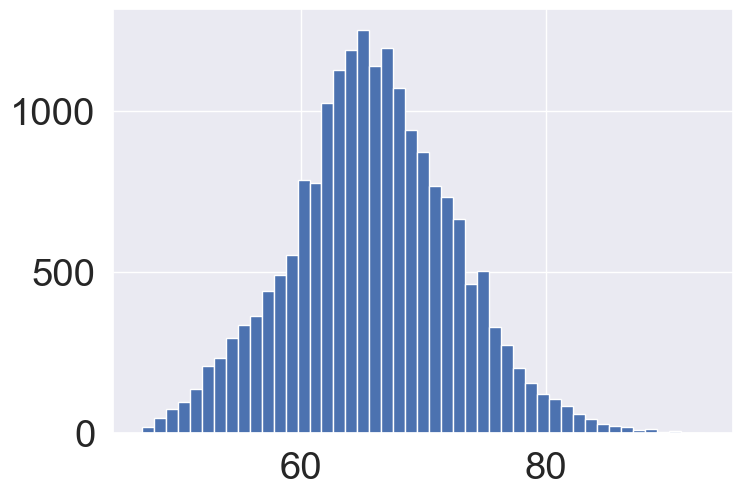

In [18]:
# Visualizamos la variable Overall que se calcula usando otras variables de habilidad del jugador y que nos brinda una idea global de desempeño
nbins = 1 * (df.overall.max() - df.overall.min()) + 1
df["overall"].hist(bins = nbins)
print(nbins)

In [19]:
# Para aligerar los procesos y mejorar la interpretación de los datos, solo utilizamos los mejores jugadores basados en el Overall 
df_ov = df[(data_nums["overall"] > 70)] # Contemplamos solo los mejores jugadores

# Aparte generamos el dataframe de skills
df_skills = df_ov[Skills]

El clustering es una técnica de exploración de datos importante con muchas aplicaciones en la minería de datos. Kmeans es uno de los métodos más conocidos de minería de datos que divide un conjunto de datos en grupos según determinados patrones. Se han propuesto muchos métodos para mejorar el rendimiento del algoritmo K-means. La estandarización es el paso central de preprocesamiento en la minería de datos, para estandarizar valores de características o atributos de diferentes rangos dinámicos en un rango específico.

In [20]:
df_skills_z = df_skills.select_dtypes(include='number').apply(stats.zscore)

In [21]:
df_skills_z.head()

,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking_awareness,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes
0,1.4,2.0,0.6,1.7,1.9,1.7,1.8,2.2,2.0,1.7,1.6,0.8,1.6,3.9,2.0,1.6,-0.1,0.1,-0.1,1.8,-1.2,-0.7,1.6,2.4,1.2,2.9,-1.6,-0.9,-1.2,-0.6,-0.3,-0.1,-0.1,-0.4
1,0.7,2.0,1.7,1.2,1.9,1.1,1.1,1.8,0.5,1.2,0.6,0.8,0.6,3.8,1.1,1.9,1.3,0.4,1.4,1.5,1.0,-0.3,1.7,1.3,2.1,2.0,-0.9,-0.6,-1.4,-0.1,-0.6,-0.2,-0.5,-0.3
2,1.5,2.0,1.7,0.9,1.8,1.2,1.2,1.7,1.0,1.2,1.2,1.4,1.2,3.9,0.5,2.3,2.1,0.5,0.6,1.8,-0.1,-1.2,1.7,0.9,2.0,2.8,-1.4,-1.0,-1.2,-0.5,-0.3,-0.1,-0.1,-0.3
3,1.4,1.4,0.2,1.3,1.8,1.6,1.6,1.9,1.3,1.7,1.7,1.4,1.9,3.1,1.2,1.1,-0.4,0.7,-1.5,1.2,-0.1,-0.8,1.3,2.0,2.3,2.6,-0.9,-1.0,-1.0,-0.4,-0.4,-0.1,-0.1,-0.3
4,1.9,1.3,-0.2,1.9,1.6,1.2,1.4,1.7,2.1,1.4,0.5,0.5,0.8,3.4,0.8,2.0,-0.5,1.3,0.3,1.7,0.7,0.5,1.4,2.3,1.7,2.1,0.6,0.4,0.1,-0.1,-0.2,-0.6,-0.4,-0.2


# 3. Aplicación de Técnicas de Clustering

El clustering es una técnica que minimiza la distancia entre los objetos de un mismo grupo y maximiza la distancia entre los objetos de distintos grupo o cluster. Para el presente trabajo, analizaremos el uso de dos técnicas de clustering, K-means y DBSCAN.

In [22]:
# Definimos a priori un número de clusters ya que es un hiperparámetro del algoritmo
n_cluster = 5


km = KMeans(
    n_clusters=n_cluster,
    init = 'k-means++',
    random_state=42
)


y_km = km.fit_predict(df_skills_z)

In [23]:
# Recuperacion de etiquetas
clusters = km.labels_
print("Suma de los cuadrados de las distancias al cluster: Inertia= ", km.inertia_)

Suma de los cuadrados de las distancias al cluster: Inertia=  46751.266273471694


In [24]:
y_km

array([2, 4, 4, ..., 3, 4, 0])

# Plotting the KMeans Clusters

In [25]:
df_skills_z["cluster"] = pd.Series(y_km, index=df_skills_z.index)

In [26]:
df_skills_z

,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking_awareness,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,cluster
0,1.4,2.0,0.6,1.7,1.9,1.7,1.8,2.2,2.0,1.7,1.6,0.8,1.6,3.9,2.0,1.6,-0.1,0.1,-0.1,1.8,-1.2,-0.7,1.6,2.4,1.2,2.9,-1.6,-0.9,-1.2,-0.6,-0.3,-0.1,-0.1,-0.4,2
1,0.7,2.0,1.7,1.2,1.9,1.1,1.1,1.8,0.5,1.2,0.6,0.8,0.6,3.8,1.1,1.9,1.3,0.4,1.4,1.5,1.0,-0.3,1.7,1.3,2.1,2.0,-0.9,-0.6,-1.4,-0.1,-0.6,-0.2,-0.5,-0.3,4
2,1.5,2.0,1.7,0.9,1.8,1.2,1.2,1.7,1.0,1.2,1.2,1.4,1.2,3.9,0.5,2.3,2.1,0.5,0.6,1.8,-0.1,-1.2,1.7,0.9,2.0,2.8,-1.4,-1.0,-1.2,-0.5,-0.3,-0.1,-0.1,-0.3,4
3,1.4,1.4,0.2,1.3,1.8,1.6,1.6,1.9,1.3,1.7,1.7,1.4,1.9,3.1,1.2,1.1,-0.4,0.7,-1.5,1.2,-0.1,-0.8,1.3,2.0,2.3,2.6,-0.9,-1.0,-1.0,-0.4,-0.4,-0.1,-0.1,-0.3,2
4,1.9,1.3,-0.2,1.9,1.6,1.2,1.4,1.7,2.1,1.4,0.5,0.5,0.8,3.4,0.8,2.0,-0.5,1.3,0.3,1.7,0.7,0.5,1.4,2.3,1.7,2.1,0.6,0.4,0.1,-0.1,-0.2,-0.6,-0.4,-0.2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4588,-0.7,0.0,-0.5,0.5,-0.7,0.0,-0.1,0.7,0.7,0.1,-0.3,-0.6,-0.5,-0.7,-0.6,-1.3,-0.7,-0.1,-1.5,0.4,-0.4,0.7,0.4,0.9,0.3,0.4,0.3,0.7,-0.3,-0.3,-0.5,-0.2,-0.2,-0.4,0
4589,0.4,0.3,0.2,0.4,0.3,0.4,0.8,0.6,0.5,0.1,0.1,-0.2,0.4,-0.5,-0.1,0.5,-0.2,0.7,0.6,0.4,1.1,0.7,0.4,0.5,0.7,0.5,0.3,0.8,0.7,-0.3,-0.5,-0.5,-0.1,-0.4,0
4590,0.6,0.3,-0.5,0.2,-1.2,0.3,0.8,-0.8,0.4,0.3,0.8,1.0,-0.1,-2.5,-0.1,-1.9,0.0,0.2,-0.0,-0.8,-0.8,0.4,0.3,-0.3,-0.9,0.1,0.6,0.7,0.7,-0.2,-0.2,-0.3,-0.1,-0.4,3
4591,0.3,0.9,0.7,-0.4,0.3,0.1,-0.1,-0.1,-0.4,-0.2,0.8,0.4,-0.9,-0.3,0.6,0.5,-0.1,-0.3,0.3,0.3,0.3,-1.1,0.7,-0.3,0.5,-1.1,-0.9,-0.7,-0.8,-0.1,-0.1,-0.1,-0.2,-0.4,4


In [27]:
label_0 = df_skills_z[df_skills_z["cluster"] == 0]
label_1 = df_skills_z[df_skills_z["cluster"] == 1]
label_2 = df_skills_z[df_skills_z["cluster"] == 2]
label_3 = df_skills_z[df_skills_z["cluster"] == 3]
label_4 = df_skills_z[df_skills_z["cluster"] == 4]

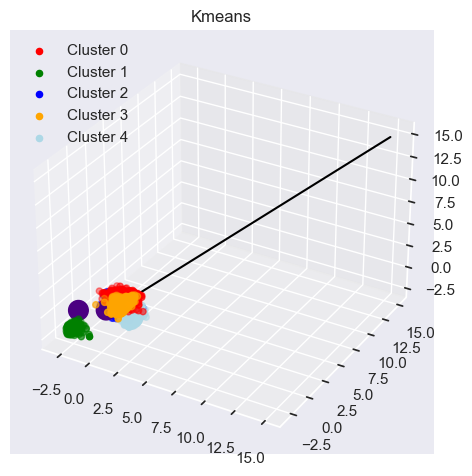

In [28]:
sns.set(font_scale=1)


kplot = plt.axes(projection="3d")


xline = np.linspace(0, 15, 1000)
yline = np.linspace(0, 15, 1000)
zline = np.linspace(0, 15, 1000)


kplot.plot3D(xline, yline, zline, "black")


kplot.scatter3D(label_0.attacking_heading_accuracy, label_0.skill_dribbling, label_0.defending_marking_awareness, c="red", label = "Cluster 0")
kplot.scatter3D(label_1.attacking_heading_accuracy, label_1.skill_dribbling, label_1.defending_marking_awareness, c="green", label = "Cluster 1")
kplot.scatter3D(label_2.attacking_heading_accuracy, label_2.skill_dribbling, label_2.defending_marking_awareness, c="blue", label = "Cluster 2")
kplot.scatter3D(label_3.attacking_heading_accuracy, label_3.skill_dribbling, label_3.defending_marking_awareness, c="orange", label = "Cluster 3")
kplot.scatter3D(label_4.attacking_heading_accuracy, label_4.skill_dribbling, label_4.defending_marking_awareness, c="lightblue", label = "Cluster 4")


plt.scatter(km.cluster_centers_[:,0], km.cluster_centers_[:,1], color="indigo", s=200)
plt.legend()
plt.title("Kmeans")
plt.show()

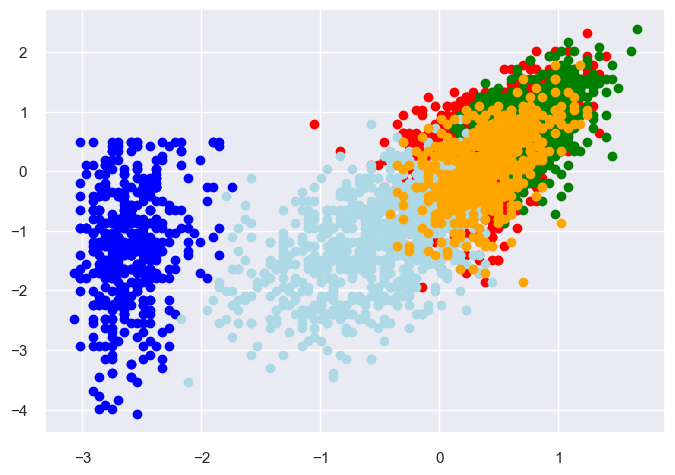

In [29]:
plt.scatter(label_0.skill_dribbling, label_0.mentality_vision, color = "red")
plt.scatter(label_1.skill_dribbling, label_1.mentality_vision, color = "blue")
plt.scatter(label_2.skill_dribbling, label_2.mentality_vision, color = "green")
plt.scatter(label_3.skill_dribbling, label_3.mentality_vision, color = "lightblue")
plt.scatter(label_4.skill_dribbling, label_4.mentality_vision, color = "orange")
plt.show()

# A continuación se determina el número óptimo de clusters y se compara ambos métodos (Elbow Method and Silhouette Method)

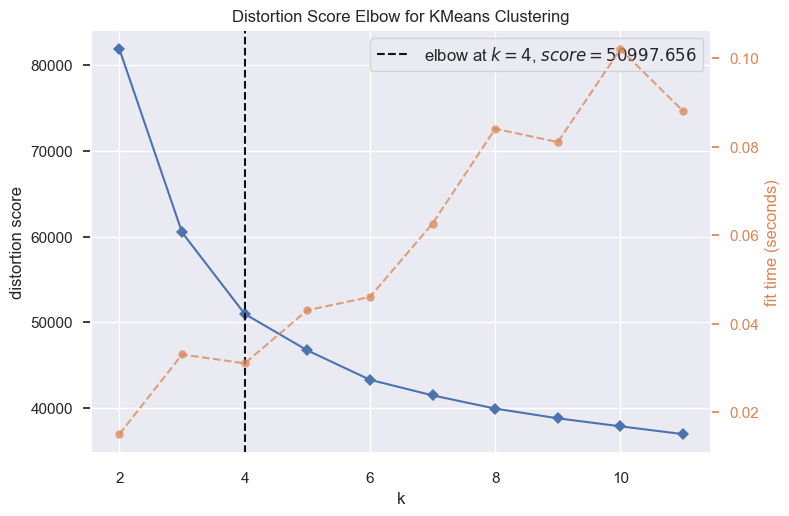

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [30]:
df_skills_z_new = df_skills.select_dtypes(include="number").apply(stats.zscore)

km = KMeans(
    random_state=42
)

visualizer = KElbowVisualizer(km, k=(2,12))
visualizer.fit(df_skills_z_new)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

Se puede interpretar que el numero optimo de clusters es igual 4.

La puntuación de la silueta en un punto mide qué tan cerca se encuentra ese punto de sus puntos vecinos más cercanos, en todos los grupos. Proporciona información sobre la calidad del agrupamiento que se puede utilizar para determinar si se debe realizar un refinamiento adicional mediante el agrupamiento en el agrupamiento actual.

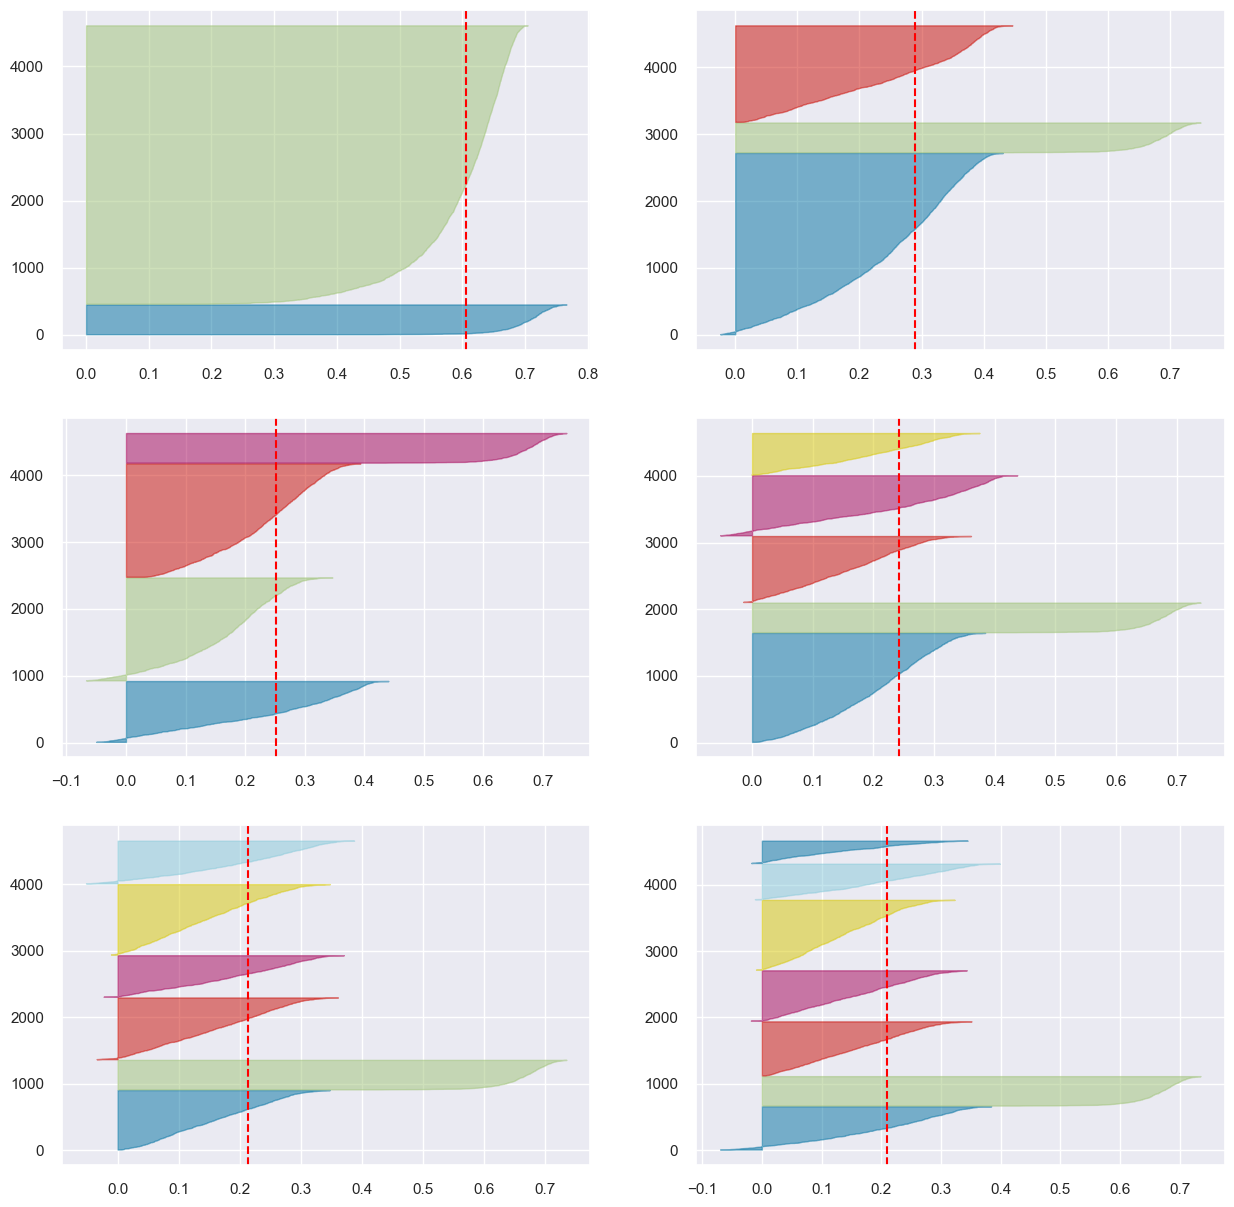

In [44]:
fig, ax = plt.subplots(3, 2, figsize=(15,15))

for i in range(2, 8):
    '''
    Create KMeans instance for different number of clusters
    '''
    km = KMeans(n_clusters=i, init="k-means++", n_init=10, max_iter=100, random_state=42)
    q, mod = divmod(i, 2)
    '''
    Create SilhouetteVisualizer instance with KMeans instance
    Fit the visualizer
    '''
    visualizer = SilhouetteVisualizer(km, colors="yellowbrick", ax=ax[q-1][mod])
    visualizer.fit(df_skills_z_new) 

# Puntuación Silhouette

In [45]:
# Instantiate the KMeans models

for i in range(2, 8):
    #
    km = KMeans(n_clusters=i, random_state=42)
    #
    # Fit the KMeans model
    #
    km.fit_predict(df_skills_z_new)
    #
    # Calculate Silhoutte Score
    #
    score = silhouette_score(df_skills_z_new, km.labels_, metric="euclidean")
    #
    # Print the score
    #
    print(f"Clusters {i} and Silhouette Score: {score}")

Clusters 2 and Silhouette Score: 0.6055620290927084
Clusters 3 and Silhouette Score: 0.28935143556573284
Clusters 4 and Silhouette Score: 0.2511232809958232
Clusters 5 and Silhouette Score: 0.2420943098277181
Clusters 6 and Silhouette Score: 0.2140904878829671
Clusters 7 and Silhouette Score: 0.2088682544640714


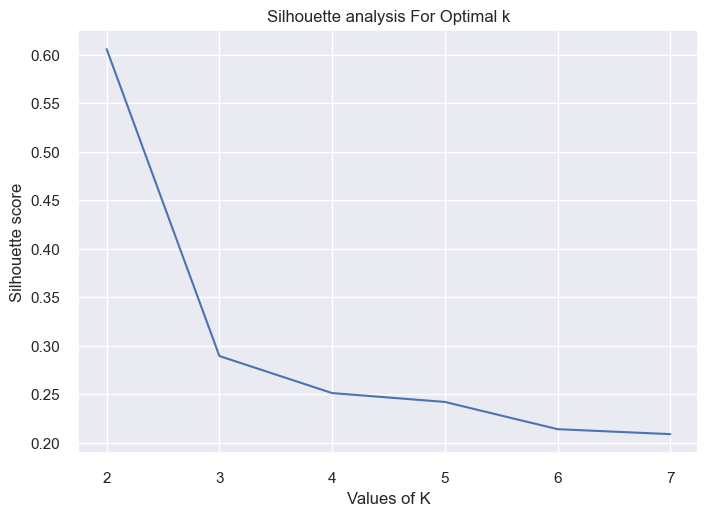

In [48]:
silhouette_avg = []

for i in range(2, 8):
 
    # initialise kmeans
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(df_skills_z_new)
    cluster_labels = kmeans.labels_
 
    # silhouette score
    silhouette_avg.append(silhouette_score(df_skills_z_new, cluster_labels))


plt.plot(range(2, 8), silhouette_avg, "bx-")    
plt.xlabel("Values of K") 
plt.ylabel("Silhouette score") 
plt.title("Silhouette analysis For Optimal k")
plt.show()

# Cantidad de observaciones por clusters

In [49]:
df_skills_z.groupby("cluster").size()

cluster
0    1635
1     444
2     989
3     901
4     624
dtype: int64

# Análisis descriptivo por cluster